In [1]:
import nest
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from utils.extractors import filter_spikes_parallel
import scipy


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.2
 Built: Mar 29 2023 08:43:05

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.




Oct 23 16:50:39 SimulationManager::set_status [Info]: 
    Temporal resolution changed.

Oct 23 16:50:40 NodeManager::prepare_nodes [Info]: 
    Preparing 2252 nodes for simulation.

Oct 23 16:50:40 MUSICManager::enter_runtime [Info]: 
    Entering MUSIC runtime with tick = 1 ms
Encoding spikes: {'senders': array([ 27,  33,  40, ..., 491, 496, 497]), 'times': array([1.e+00, 1.e+00, 1.e+00, ..., 3.e+03, 3.e+03, 3.e+03])}

Oct 23 16:50:40 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 2252
    Simulation time (ms): 3000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Oct 23 16:50:44 SimulationManager::run [Info]: 
    Simulation finished.


Filtering SpikeTrains: 100%|█████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 138.99it/s]


Circuit Spikes: {'senders': array([1002, 1006, 1042, ..., 1959, 1977, 1989]), 'times': array([  11.,   11.,   11., ..., 3000., 3000., 3000.])}


Filtering SpikeTrains: 100%|███████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 136.48it/s]


Encoding Layer: 
	- Capacity=0.9826942511866287, MSE=0.009021152146918078
Main Circuit: 
	- Capacity=0.9565058655075453, MSE=0.02852013190270348


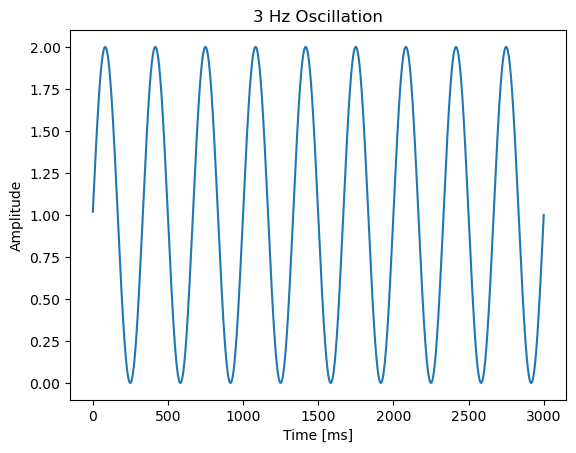

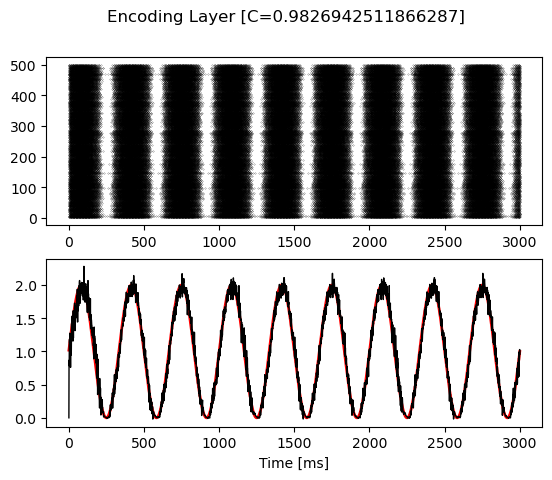

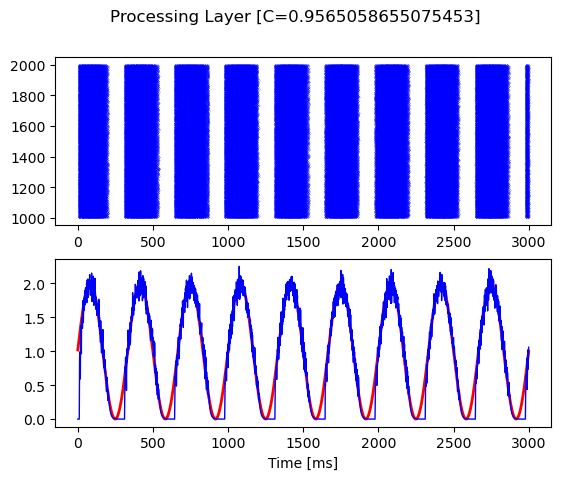

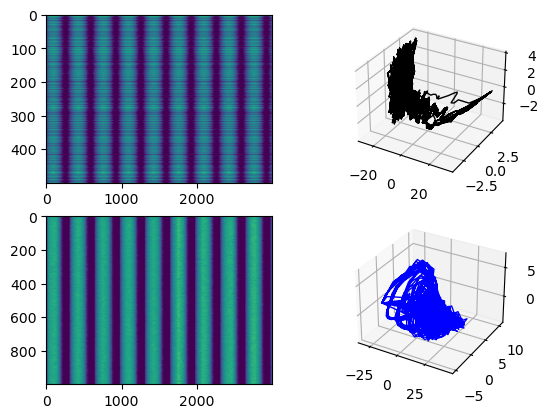

Lag = 1.0 ms
Encoding Layer: 
	- Capacity=0.9826942511866287, MSE=0.009021152146918078
Main Circuit: 
	- Capacity=0.9565058655075453, MSE=0.02852013190270348
Lag = 11.0 ms
Encoding Layer: 
	- Capacity=0.999221117913328, MSE=0.0007274478831224121
Main Circuit: 
	- Capacity=0.9833560610888581, MSE=0.011908650917200378
Lag = 21.0 ms
Encoding Layer: 
	- Capacity=0.9937259550893311, MSE=0.003493809652842624
Main Circuit: 
	- Capacity=0.9869942759411284, MSE=0.009519787629154263
Lag = 31.0 ms
Encoding Layer: 
	- Capacity=0.9689138878560757, MSE=0.016002279469087246
Main Circuit: 
	- Capacity=0.9725970641097568, MSE=0.01791687072191457
Lag = 41.0 ms
Encoding Layer: 
	- Capacity=0.9310520777022347, MSE=0.0351035106970965
Main Circuit: 
	- Capacity=0.9429334360191547, MSE=0.036289626184506235
Lag = 51.0 ms
Encoding Layer: 
	- Capacity=0.8848043432337557, MSE=0.05841573600386373
Main Circuit: 
	- Capacity=0.9003063428342383, MSE=0.06475885955993278
Lag = 61.0 ms
Encoding Layer: 
	- Capacity=0.83

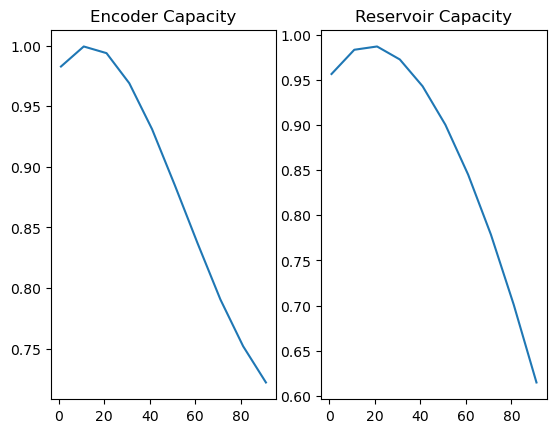

Total capacity (encoder): 88.62251014592344 ms
Total capacity (processor): 86.82318830968454 ms


In [2]:
#frequencies = [3,10,30, 50, 70]  # Frequencies in Hz
frequencies = [3] # Frequencies in Hz

duration = 3000 #ms
dt = 1.
t = np.arange(0,duration,dt)+dt

frequency_capacity = []

for i in range(len(frequencies)):
    nest.ResetKernel()
    nest.resolution = dt
    frequency = frequencies[i]
    signal = (np.sin(2 * np.pi * frequency * t/1000)+1)
    pl.figure()
    pl.plot(t, signal)
    pl.xlim()
    pl.xlabel(r'Time [ms]')
    pl.ylabel(r'Amplitude')
    pl.title(f'{frequency} Hz Oscillation')


# Parameters
    nEnc = 500  # number of neurons in the encoding layer
    J_bias = 200. # [pA] 
    tuning = 250. * np.random.randn(nEnc) + 1000.

    thresholds = 5 * np.random.randn(nEnc) - 50.
    Vm0 = np.array(np.random.uniform(low=-70., high=-50., size=int(nEnc)))
    enc_layer = nest.Create('iaf_psc_delta', nEnc, {'I_e': J_bias})
    alpha = 2.5  

    step_generator = nest.Create('step_current_generator', nEnc)
    amplitudes = np.zeros((nEnc, len(signal)))
    for n in range(nEnc):
        amplitudes[n, :] = signal * tuning[n]
        enc_layer[n].set({'V_m': Vm0[n], 'V_th': thresholds[n]})
        # print(amplitudes[0])
        # print(t)
        step_generator[n].set({'amplitude_times': t, 'amplitude_values': amplitudes[n]})
        nest.Connect(step_generator[n], enc_layer[n])
    enc_spks = nest.Create('spike_recorder')
    nest.Connect(enc_layer, enc_spks)

    gamma = 0.25               # relative number of inhibitory connections
    NE = 1000                  # number of excitatory neurons (10.000 in [1])
    NI = int(gamma * NE)       # number of inhibitory neurons
    CE = 200                  # indegree from excitatory neurons
    CI = int(gamma * CE)       # indegree from inhibitory neurons

# synapse parameters
    w = 0.1                    # excitatory synaptic weight (mV)
    g = 5.                     # relative inhibitory to excitatory synaptic weight
    d = 1.5                    # synaptic transmission delay (ms)

# neuron paramters
    neuron_params = {
        'C_m': 1.0,            # membrane capacity (pF)
        'E_L': 0.,             # resting membrane potential (mV)
        'I_e': 0.,             # external input current (pA)
        'V_m': 0.,             # membrane potential (mV)
        'V_reset': 10.,        # reset membrane potential after a spike (mV)
        'V_th': 20.,           # spike threshold (mV)
        't_ref': 2.0,          # refractory period (ms)
        'tau_m': 20.,          # membrane time constant (ms)
    }
    # set default parameters for neurons and create neurons
    nest.SetDefaults('iaf_psc_delta', neuron_params)
    neurons_e = nest.Create('iaf_psc_delta', NE)
    neurons_i = nest.Create('iaf_psc_delta', NI)

    # create spike detectors
    spikes_e = nest.Create('spike_recorder')
    # E synapses
    syn_exc = {'delay': d, 'weight': w}
    conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
    nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
    nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

    # I synapses
    syn_inh = {'delay': d, 'weight': - g * w}
    conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
    nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
    nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

    # spike detector
    nest.Connect(neurons_e, spikes_e)

    nest.Connect(enc_layer, neurons_e, conn_exc, syn_exc)
    nest.Connect(enc_layer, neurons_i, conn_exc, syn_exc)
    nest.Simulate(duration)

    #this filters the spikes from the encoding layer 
    filter_tau = 10. # [ms]
    num_threads = 8
    t_stop = duration

    enc_activity = enc_spks.events
    
    print("Encoding spikes:", enc_activity)
    
    enc_states = filter_spikes_parallel(enc_activity['times'], enc_activity['senders'], nEnc, t_start=0., 
                                        t_stop=t_stop, dt=dt, tau=filter_tau, n_processes=num_threads)


    e_activity = spikes_e.events
    
    print("Circuit Spikes:", e_activity)
    # e_states = filter_spikes(e_activity['times'], e_activity['senders'], NE, t_start=0., t_stop=T*duration, dt=dt, tau=filter_tau)

# if you can use parallelization, it can be very useful here:
    e_states = filter_spikes_parallel(e_activity['times'], e_activity['senders'], NE, t_start=0., t_stop=t_stop, 
                                      dt=dt, tau=filter_tau, n_processes=num_threads)

    def compute_capacity(x, z):
        """
        Compute capacity to reconstruct z based on linearly combining x

        Parameters
        ----------
        x : np.ndarray
            state matrix(NxT)
        z : np.ndarray
            target output (1xT)

        Returns
        -------
        z_hat : np.ndarray
            Reconstructed (predicted) signal

        """
        reg = LinearRegression(n_jobs=-1, fit_intercept=False).fit(x.T, z)
        W_out = reg.coef_
        z_hat = np.dot(W_out, x)

        covs = np.cov(z_hat, z)[0, 1] ** 2.0
        vars = np.var(z) * np.var(z_hat)
        capacity = covs / vars

        error = np.mean((z - z_hat) ** 2)
        return z_hat, capacity, error

    enc_estimate, enc_capacity, enc_error = compute_capacity(enc_states, signal)
    circ_estimate, circ_capacity, circ_error = compute_capacity(e_states, signal)

    print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
    print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

    fig = pl.figure()
    fig.suptitle('Encoding Layer [C={0}]'.format(str(enc_capacity)))
    ax11 = fig.add_subplot(211)
    ax12 = fig.add_subplot(212, sharex=ax11)
    ax11.plot(enc_activity['times'], enc_activity['senders'], '.k', markersize=0.3)
    ax12.plot(t, signal, 'r', linewidth=2)
    ax12.plot(t, enc_estimate, 'k', linewidth=1)
    ax12.set_xlabel(r'Time [ms]')
    pl.show()
    
    fig = pl.figure()
    fig.suptitle('Processing Layer [C={0}]'.format(str(circ_capacity)))
    ax11 = fig.add_subplot(211)
    ax12 = fig.add_subplot(212, sharex=ax11)
    ax11.plot(e_activity['times'], e_activity['senders'], '.b', markersize=0.3)
    ax12.plot(t, signal, 'r', linewidth=2)
    ax12.plot(t, circ_estimate, 'b', linewidth=1)
    ax12.set_xlabel(r'Time [ms]')
    pl.show()

    fig = pl.figure()
    ax1 = fig.add_subplot(221)
    ax1.imshow(enc_states, aspect='auto')
    ax2 = fig.add_subplot(222, projection='3d')
    pca_fit_enc = PCA(n_components=3)
    X_enc = pca_fit_enc.fit_transform(enc_states.T)
    ax2.plot(X_enc[:, 0], X_enc[:, 1], X_enc[:, 2], color='k', lw=1)
    ax3 = fig.add_subplot(223)
    ax3.imshow(e_states, aspect='auto')
    ax4 = fig.add_subplot(224, projection='3d')
    pca_fit_enc = PCA(n_components=3)
    X_cir = pca_fit_enc.fit_transform(e_states.T)
    ax4.plot(X_cir[:, 0], X_cir[:, 1], X_cir[:, 2], color='b', lw=1)
    pl.show()
    
    
    max_lag = 100.  # [ms] in this example
    step_lag = 10  # [ms] - if != dt (index the time axis)
    time_lags = np.arange(0., max_lag, step_lag)+dt
    indices = [np.where(idx == t)[0][0] for idx in time_lags]

    encoder_capacity = []
    circuit_capacity = []

    for idx, lag in zip(indices, time_lags):

        # shift the target signal
        if idx > 0:
            shifted_signal = signal[:-idx]
        else:
            shifted_signal = signal

        # shift the population states
        enc_st = enc_states[:, idx:]
        circ_st = e_states[:, idx:]

        # compute capacity
        enc_estimate, enc_capacity, enc_error = compute_capacity(enc_st, shifted_signal)
        circ_estimate, circ_capacity, circ_error = compute_capacity(circ_st, shifted_signal)

        print("Lag = {0} ms".format(str(lag)))
        print("Encoding Layer: \n\t- Capacity={0}, MSE={1}".format(str(enc_capacity), str(enc_error)))
        print("Main Circuit: \n\t- Capacity={0}, MSE={1}".format(str(circ_capacity), str(circ_error)))

        encoder_capacity.append(enc_capacity)
        circuit_capacity.append(circ_capacity)

    fig = pl.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.plot(time_lags, encoder_capacity)
    ax1.set_title("Encoder Capacity")
    ax2.plot(time_lags, circuit_capacity)
    ax2.set_title("Reservoir Capacity")

    pl.show()

    print("Total capacity (encoder): {0} ms".format(str(np.sum(encoder_capacity)*step_lag)))
    print("Total capacity (processor): {0} ms".format(str(np.sum(circuit_capacity)*step_lag)))
    
    